In [1]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
#load Data


df = pd.read_csv('C:\\Users\\SAIL\\stapler-ds (1).csv',parse_dates=True)
df

,Unnamed: 0,id,TimeMS,Avg_Velocity,PWM_Output,SG_NoFilter,Setpoint,StrainGage,avg_current,current_filter,ticks,True_Endstop_Time_ms,Articulation,Tissue,Tissue_Thickness_inch,Firing_Type
0,0,100,0,0.00,153,11,33750,1,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
1,1,100,1,0.00,165,11,33750,2,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
2,2,100,2,0.00,176,11,33750,4,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
3,3,100,3,0.00,188,11,33750,5,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
4,4,100,4,0.00,199,11,33750,6,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183005,3183005,97,4642,93.75,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183006,3183006,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183007,3183007,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183008,3183008,97,4644,31.25,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted


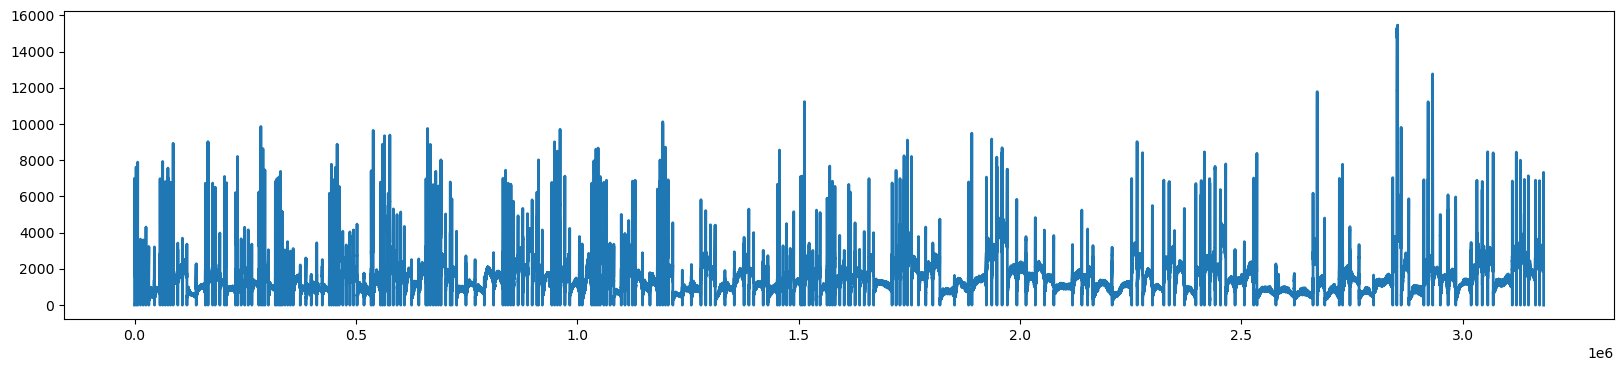

In [33]:
df.index.freq = 'TimeMS'
df.shape
df.columns
plt.figure(figsize=(20, 4))
plt.plot(df.avg_current, linewidth=2)
plt.show()

In [34]:
cols = ['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']
df = df[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'}, axis=1)

measures = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output', 'Anomaly_At_Time_ms', 'id', 'TimeMS']

for i in range(1,6):
  measure=measures[i-1]
  print(measure.title())
df=df[measures]

Avg_Velocity
Straingage
Avg_Current
Pwm_Output
Anomaly_At_Time_Ms


In [35]:
df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,id,TimeMS
0,0.00,1,0,153,3360,100,0
1,0.00,2,0,165,3360,100,1
2,0.00,4,0,176,3360,100,2
3,0.00,5,0,188,3360,100,3
4,0.00,6,0,199,3360,100,4
...,...,...,...,...,...,...,...
3183005,93.75,128,0,0,4363,97,4642
3183006,62.50,128,0,0,4363,97,4643
3183007,62.50,128,0,0,4363,97,4643
3183008,31.25,128,0,0,4363,97,4644


In [36]:
def plot_measure(df):
  e=np.unique(df['Anomaly_At_Time_ms'])[0]
  df=df[df.TimeMS > 400]
  #plt.plot('TimeMS','StrainGage',data=df)
  #plt.plot('TimeMS','Avg_Velocity',data=df)
  plt.figure(figsize=(16,12))
  for i in range(1,5):
    measure=measures[i-1]
    plt.subplot(2,2,i)
    plt.title(measure.title() + ' from a surgical instrument')
    # naming the x axis
    plt.xlabel('Time in Milliseconds')
    # naming the y axis
    plt.ylabel(measure.title())
    plt.plot('TimeMS',measure,data=df)
    #plt.plot('TimeMS','avg_current',data=df)
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')
  plt.show()

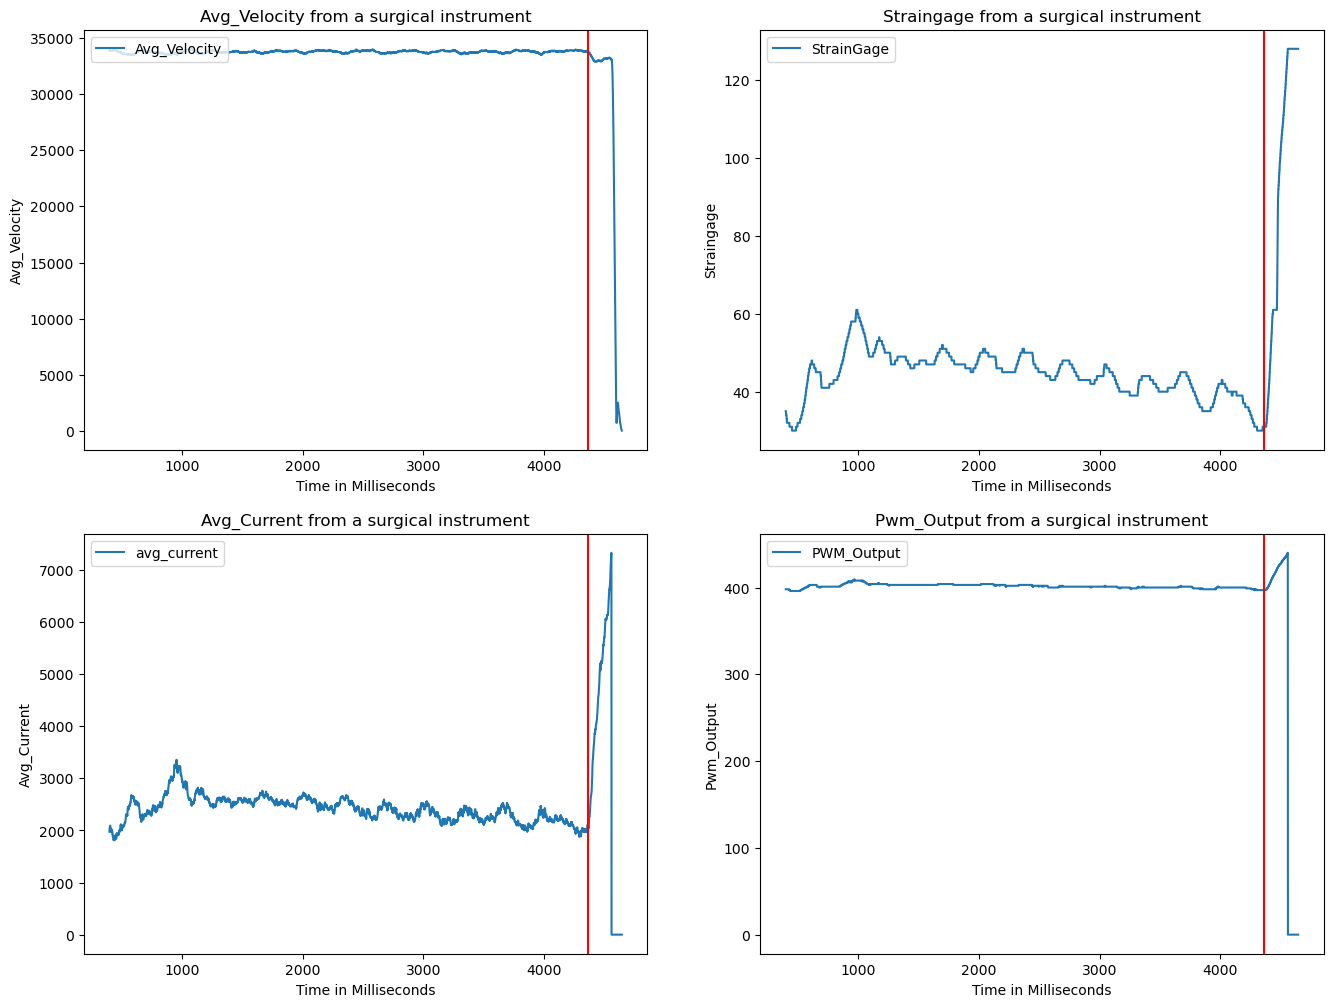

In [37]:
df_97=df["id"]==97
plot_measure(df[df_97])

In [38]:
df[['TimeMS','id']].groupby('id').count()

,TimeMS
id,
2,3764
3,3681
4,7436
5,7468
6,7376
...,...
366,12422
368,22102
370,12286


In [39]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming your DataFrame is named 'df'
# ... (previous code to define 'df' and other steps)

# Step 6: Pad sequences to ensure each 'id' has the same length as the maximum sequence length
max_seq_length = df[['TimeMS', 'id']].groupby('id').count().max().values[0]

# Create a dictionary to store sequences for each 'id' group
id_sequences = {}

# Group data by 'id' and store sequences in the dictionary
for id_group in df.groupby('id'):
    id_value, group_df = id_group
    sequence = group_df['TimeMS'].values
    id_sequences[id_value] = sequence

# Pad each sequence individually using the pad_sequences function for 'TimeMS'
padded_sequences = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in id_sequences.values()]

# Initialize a dictionary to store the padded sequences for each column
padded_data_dict = {}

# Pad each sequence individually using the pad_sequences function for other columns
for col in df.columns:
    if col not in ['TimeMS', 'id']:
        sequences = [group_df[col].values for _, group_df in df.groupby('id')]
        padded_sequences_col = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in sequences]
        padded_data_dict[col] = np.concatenate(padded_sequences_col, axis=0)

# Add 'Padded_TimeMS' column to the dictionary
padded_data_dict['Padded_TimeMS'] = np.concatenate(padded_sequences, axis=0)

# Add 'id' column to the dictionary
padded_data_dict['id'] = np.repeat(df['id'].unique(), max_seq_length)

# Create the final DataFrame with padded sequences for all columns
padded_df = pd.DataFrame(data=padded_data_dict)

# Now, 'padded_df' contains the data with padded sequences, and each 'id' has the same length as the maximum sequence length


In [40]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id
0,0,0,0,0,0,0,100
1,0,0,0,0,0,0,100
2,0,0,0,0,0,0,100
3,0,0,0,0,0,0,100
4,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97
10991996,62,163,0,0,10522,11050,97
10991997,62,163,0,0,10522,11050,97
10991998,31,163,0,0,10522,11051,97


In [41]:
padded_df[['Padded_TimeMS','id']].groupby('id').count()



,Padded_TimeMS
id,
2,43968
3,43968
4,43968
5,43968
6,43968
...,...
366,43968
368,43968
370,43968


In [42]:
import pandas as pd

# Assuming your dataset is already loaded into the DataFrame called "padded_df"
# If not, you can load it from your data source using pd.read_csv or any other method.

# Add a new column "Label" and initialize it with 0
padded_df['Label'] = 0

# Update "Label" to 1 for rows where "Padded_TimeMS" is greater than "Anomaly_At_Time_ms"
padded_df.loc[padded_df['Padded_TimeMS'] > padded_df['Anomaly_At_Time_ms'], 'Label'] = 1




In [43]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [15]:
#padded_df.to_csv("padded.csv", index=False)

In [44]:
features = padded_df[['Avg_Velocity','StrainGage','avg_current','PWM_Output']]
label = padded_df['Label']

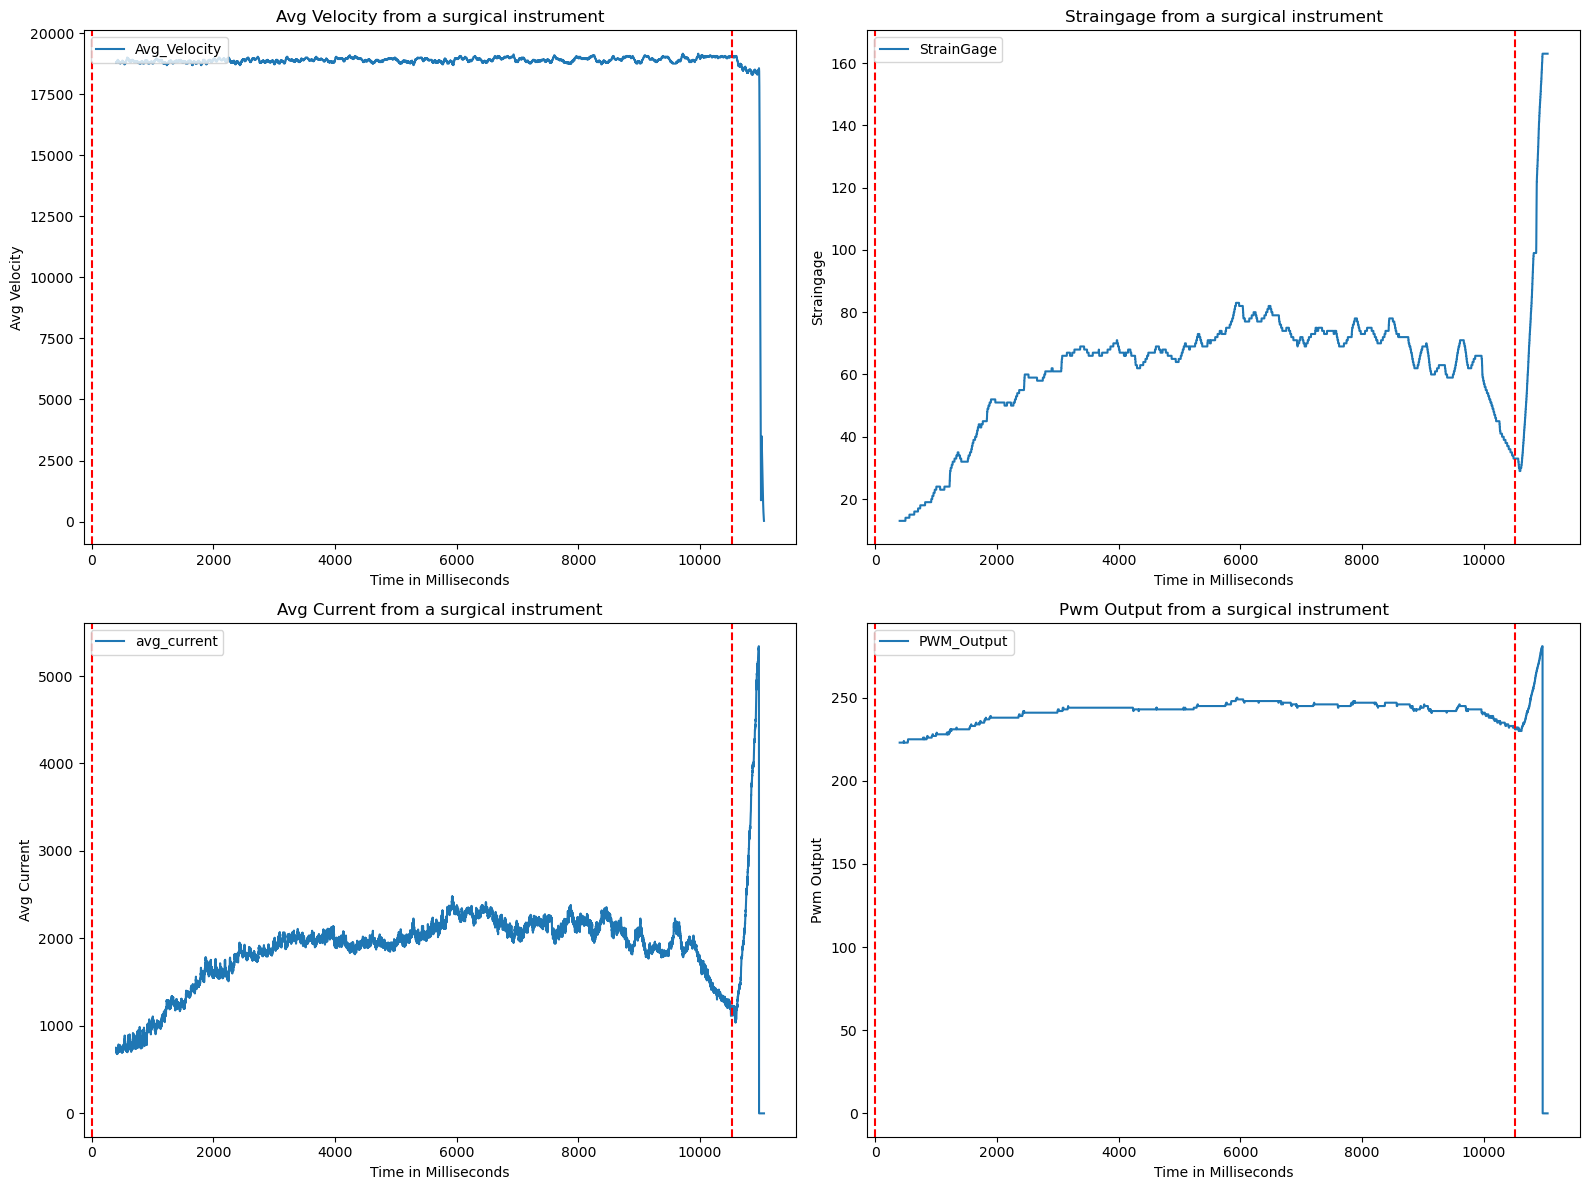

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_measure(padded_df):
    unique_times = np.unique(padded_df['Anomaly_At_Time_ms'])
    df = padded_df[padded_df['Padded_TimeMS'] > 400]

    plt.figure(figsize=(16, 12))

    for i, measure in enumerate(['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output']):
        plt.subplot(2, 2, i+1)
        plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
        plt.xlabel('Time in Milliseconds')
        plt.ylabel(measure.replace('_', ' ').title())
        plt.plot('Padded_TimeMS', measure, data=df)

        # Add vertical lines for each unique Anomaly_At_Time_ms value
        for t in unique_times:
            plt.axvline(t, color='r', linestyle='--')

        plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Assuming you have the 'padded_df' DataFrame
padded_df_97 = padded_df[padded_df["id"] == 97]
plot_measure(padded_df_97)


In [56]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [60]:
import numpy as np

# Separate features and labels for training and testing sets
X = padded_df.drop(['Label', 'id', 'Anomaly_At_Time_ms', 'Padded_TimeMS'], axis=1)
Y = padded_df[['Label']]

# Convert data to numpy arrays
X_np = X.values
Y_np = Y.values.ravel()

# Separate normal and faulty samples
X_normal = X_np[Y_np == 0]
X_faulty = X_np[Y_np == 1]

In [61]:
X_normal.shape

(10850504, 4)

In [62]:
X_faulty.shape

(141496, 4)

In [63]:
# Number of synthetic samples to generate (you can adjust this based on your needs)
num_synthetic_samples = len(X_normal) - len(X_faulty)

print("number of sythetic sample need to be generated to balanced the normal and fault :",num_synthetic_samples)

number of sythetic sample need to be generated to balanced the normal and fault : 10709008


In [64]:
# Randomly sample from faulty samples to generate synthetic samples
synthetic_samples = X_faulty[np.random.randint(len(X_faulty), size=int(num_synthetic_samples/2))]
print(synthetic_samples.shape)


(5354504, 4)


In [65]:
# Interpolation to generate additional synthetic samples
interpolated_samples = []
for i in range(int(num_synthetic_samples/2)):
    index1 = np.random.randint(len(X_faulty))
    index2 = np.random.randint(len(X_faulty))
    alpha = np.random.uniform(0, 1)
    interpolated_sample = alpha * X_faulty[index1] + (1 - alpha) * X_faulty[index2]
    interpolated_samples.append(interpolated_sample)

# Combine original faulty samples, randomly sampled faulty samples, and interpolated samples
augmented_X_train = np.vstack((X_np,synthetic_samples,  interpolated_samples))
# Create an array of ones with the same shape as synthetic_samples
synthetic_labels = np.ones_like(synthetic_samples[:, 0])

# Combine the labels for original faulty samples, randomly sampled faulty samples, and interpolated samples
augmented_Y_train = np.hstack((Y_np, synthetic_labels, synthetic_labels))


# Shuffle the augmented data to avoid any order bias
shuffled_indices = np.random.permutation(len(augmented_X_train))
augmented_X_train = augmented_X_train[shuffled_indices]
augmented_Y_train = augmented_Y_train[shuffled_indices]

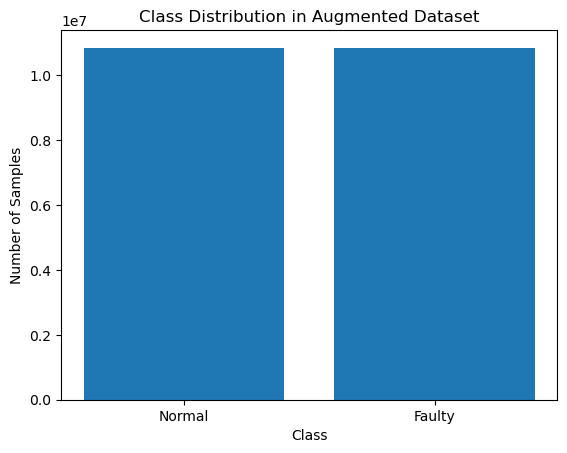

In [66]:
import matplotlib.pyplot as plt

# Count the number of normal and faulty samples in the augmented dataset
num_normal_samples = np.sum(augmented_Y_train == 0)
num_faulty_samples = np.sum(augmented_Y_train == 1)

# Create a bar plot to visualize the balance
plt.bar(['Normal', 'Faulty'], [num_normal_samples, num_faulty_samples])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Augmented Dataset')
plt.show()


In [80]:
import numpy as np

# Separate normal and faulty samples from augmented data
X_normal = augmented_X_train[augmented_Y_train == 0]
X_faulty =  augmented_X_train[augmented_Y_train ==1]
Y_normal = augmented_Y_train[augmented_Y_train == 0]
Y_faulty =  augmented_Y_train[augmented_Y_train ==1]
# Now you have the augmented data divided into X_normal and X_faulty arrays
# You can use these arrays for training your model


In [81]:
print(X_normal.shape)
print(X_faulty.shape)

(10850504, 4)
(10850504, 4)


In [82]:
from sklearn.preprocessing import StandardScaler
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_normal)

# Transform the data using the fitted scaler
X_normal_scaled = scaler.transform(X_normal)
X_faulty_scaled = scaler.transform(X_faulty)

In [84]:
print(X_normal_scaled.shape)
print(Y_normal.shape)

(10850504, 4)
(10850504,)


In [100]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 1024
n_features = 4
# Create generator for target data (Y_normal)
target_generator_train = TimeseriesGenerator(Y_normal, Y_normal, length=n_inputs, batch_size=1024)

generator_train = TimeseriesGenerator(X_normal_scaled, Y_normal, length=n_inputs, batch_size=1024)

for i in range(len(generator_train)):
    x_normal, y_normal= generator_train[i]
    print(f'\n {x_normal.flatten()} and {y_normal}')



 [ 1.48877213  2.16274695  1.74880877 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [ 3.07636395  1.05946754  2.22433533 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [3.11331217 2.0778793  2.87832828 ... 1.82327636 0.75515399 0.6644152 ] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ...  1.5262396   0.41318937
  0.62085764] and [0 0 0 ... 0 0 0]

 [ 0.46507024  3.09629106  1.28134198 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ...  1.18676901  0.29920116
  0.61214613] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ... -0.55301775 -0.51598724
 -0.55519657] and [0 0 0 ... 0 0 0]

 [-0.53177975 -0.55301775 -0.51598724 ... -0.55301775 -0.51598724
 -0.55519657]

In [87]:
x_normal.shape

(200, 1024, 4)

In [151]:
original_dim = x_normal.shape[0]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [152]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [154]:
from tensorflow.keras import regularizers
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=regularizers.l2(0.01))(x)
z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=regularizers.l2(0.01))(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 4096)]       0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 2048)         8390656     ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 1365)         2796885     ['dense_18[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 1365)         2796885     ['dense_18[0][0]']               
                                                                                            

In [155]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1365)]            0         
                                                                 
 dense_19 (Dense)            (None, 2048)              2797568   
                                                                 
 dense_20 (Dense)            (None, 4096)              8392704   
                                                                 
Total params: 11,190,272
Trainable params: 11,190,272
Non-trainable params: 0
_________________________________________________________________


In [156]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [157]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [164]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
x_normal = x_normal.reshape(-1, original_dim) # Assuming 200 is the desired input shape (n_inputs * n_features)

results = vae_model.fit(x_normal, x_normal,
                        shuffle=True,
                        epochs=300,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 4096)]            0         
                                                                 
 encoder (Functional)        (None, 1365)              13984426  
                                                                 
 decoder (Functional)        (None, 4096)              11190272  
                                                                 
Total params: 25,174,698
Trainable params: 25,174,698
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples
Epoch 1/300
200/200 [==============================] - 2s 12ms/sample - loss: 58516.7990
Epoch 2/300
200/200 [==============================] - 2s 8ms/sample - loss: 58348.4755
Epoch 3/300
200/200 [==============================] - 2s 8ms/sample - loss: 58277.5974
Epoch 4/300
200/200 [====

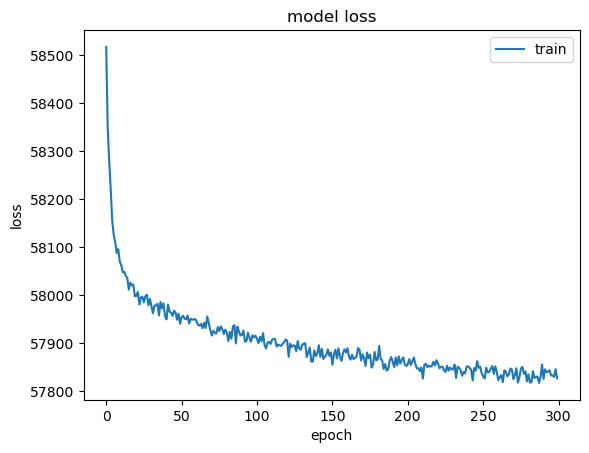

In [165]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [170]:
X_normal_pred = vae_model.predict(x_normal)

In [173]:
X_normal_pred.shape

(200, 4096)

In [174]:
mae_vector = get_error_term(X_normal_pred, x_normal, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.560444616986636
median error 0.5601766838434614
99Q: 0.5680351303760267
setting threshold on 0.5680351303760267 


In [175]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 1024
n_features = 4
# Create generator for target data (Y_normal)
target_generator_test = TimeseriesGenerator(Y_faulty, Y_faulty, length=n_inputs, batch_size=1024)

generator_test = TimeseriesGenerator(X_faulty_scaled, Y_faulty, length=n_inputs, batch_size=1024)

for i in range(len(generator_test)):
    x_faulty, y_faulty= generator_test[i]
    print(f'\n {x_faulty.flatten()} and {y_faulty}')



 [ 0.46081218  4.19957047  1.71467778 ... -0.02882684  0.03918555
  0.55165746] and [1 1 1 ... 1 1 1]

 [0.06376213 2.15745668 0.53090992 ... 3.54397474 5.93169223 3.09700109] and [1 1 1 ... 1 1 1]

 [ 0.45751745  4.49842516  2.13191953 ...  3.18315717 -0.24094882
 -0.10758264] and [1 1 1 ... 1 1 1]

 [1.46088506 2.98417146 2.38118362 ... 3.86009988 3.09824493 1.68366219] and [1 1 1 ... 1 1 1]

 [0.45830356 5.515019   2.12646667 ... 3.23997031 3.8686076  1.75118778] and [1 1 1 ... 1 1 1]

 [ 0.66982919  2.13820487 -0.18958684 ...  3.69036459  6.14138465
  3.11235027] and [1 1 1 ... 1 1 1]

 [2.19671845 1.30755507 2.23680712 ... 0.51446105 0.29053984 0.58355484] and [1 1 1 ... 1 1 1]

 [0.46839988 2.54465136 1.11554095 ... 5.11783019 0.91347308 0.15344062] and [1 1 1 ... 1 1 1]

 [0.45497393 3.98740135 1.40338996 ... 1.18676901 3.10400191 2.91198548] and [1 1 1 ... 1 1 1]

 [0.60286549 1.60920086 1.05184674 ... 2.19280452 0.49320859 0.06179279] and [1 1 1 ... 1 1 1]

 [0.45497393 3.520

In [176]:
x_faulty.shape

(200, 1024, 4)

In [177]:
y_faulty.shape

(200,)

In [179]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
x_faulty = x_faulty.reshape(-1, original_dim)

# Assuming the 'predictions'
predictions=vae_model.predict(x_faulty)
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (200,)
Y_pred = vector_reduced.reshape(200,)

print(Y_pred.shape)
Y_pred

(200,)


array([-0.4605037 , -1.7627305 ,  0.07558078, -2.327499  , -1.9534322 ,
       -2.9197648 , -2.569126  ,  3.0521827 ,  0.28257847, -1.8037763 ,
       -0.8586401 , -0.8298304 , -0.31355664, -0.7803247 , -1.4039185 ,
        0.78840387, -2.333185  , -1.5564934 ,  0.34699032, -3.4425666 ,
        3.590384  , -2.3944683 ,  1.429373  ,  2.737154  , -3.0805998 ,
        0.86311245,  1.8699875 , -2.7238226 , -1.890448  , -0.79111576,
       -0.9331196 ,  3.259835  , -2.3301995 ,  2.4883604 ,  0.4395407 ,
        1.2882973 ,  0.43869168,  0.38080284,  0.91250443, -0.75746924,
        1.0345249 , -1.2283696 , -1.4536891 ,  1.59495   , -1.1899709 ,
        0.4190088 , -2.2257051 , -1.5630237 , -2.07358   ,  1.7633139 ,
       -1.5260036 , -0.17327249, -1.1284556 , -0.4304888 , -1.0261416 ,
        0.9116631 ,  0.20574814,  4.3018584 , -0.44034272, -1.7809306 ,
       -0.9376912 ,  0.699413  , -1.7899884 , -0.24987452, -0.01496211,
        2.3731565 , -0.6234883 , -0.9328067 ,  0.78978   ,  3.41

In [180]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)

[0.3868663  0.14644869 0.5188862  0.08887097 0.12417959 0.05118512
 0.07115205 0.9548767  0.5701783  0.14139201 0.29762354 0.30368093
 0.42224687 0.3142499  0.19719504 0.6874885  0.08841164 0.17415039
 0.58588755 0.03099131 0.9731529  0.08359549 0.8068036  0.9391838
 0.04391463 0.7033105  0.86645687 0.06158219 0.1311934  0.31192914
 0.28229225 0.963025   0.08865254 0.92332184 0.6081496  0.78385884
 0.60794723 0.5940667  0.71351236 0.31919596 0.7377922  0.22646691
 0.18943445 0.8313114  0.23326415 0.60324603 0.09746579 0.1732132
 0.11169135 0.8536242  0.17857915 0.4567899  0.24444622 0.39400962
 0.2638328  0.71334034 0.55125636 0.9866376  0.39165932 0.14418826
 0.28136694 0.66805756 0.14307415 0.43785438 0.4962595  0.9147573
 0.3489885  0.28235567 0.6877841  0.96829    0.5891485  0.37147453
 0.1430533  0.7944754  0.18359001 0.5568307  0.7730485  0.8838233
 0.6123485  0.78896046 0.5342203  0.9117322  0.6623019  0.2486489
 0.9460441  0.5912993  0.9122212  0.01850849 0.8457031  0.09343332


In [181]:
Y_pred_sigmoid.shape

(200,)

In [183]:
y_faulty

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [184]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - y_faulty) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.3527647025125208


In [185]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(y_faulty * np.log(Y_pred_sigmoid + epsilon) + (1 - y_faulty) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 1.010815564917866


array([9.49676096e-01, 1.92108023e+00, 6.56070650e-01, 2.42056966e+00,
       2.08602643e+00, 2.97230625e+00, 2.64293599e+00, 4.61730361e-02,
       5.61806202e-01, 1.95621908e+00, 1.21192586e+00, 1.19177771e+00,
       8.62165153e-01, 1.15756679e+00, 1.62356198e+00, 3.74710172e-01,
       2.42575169e+00, 1.74783599e+00, 5.34627378e-01, 3.47404838e+00,
       2.72140913e-02, 2.48176575e+00, 2.14675024e-01, 6.27441108e-02,
       3.12550783e+00, 3.51956815e-01, 1.43342957e-01, 2.78738260e+00,
       2.03108263e+00, 1.16497922e+00, 1.26481235e+00, 3.76759358e-02,
       2.42303061e+00, 7.97774121e-02, 4.97334391e-01, 2.43526325e-01,
       4.97667193e-01, 5.20763695e-01, 3.37555528e-01, 1.14195013e+00,
       3.04093063e-01, 1.48515642e+00, 1.66371226e+00, 1.84750825e-01,
       1.45558381e+00, 5.05430162e-01, 2.32825375e+00, 1.75323212e+00,
       2.19201612e+00, 1.58264205e-01, 1.72272336e+00, 7.83531725e-01,
       1.40875995e+00, 9.31379974e-01, 1.33243966e+00, 3.37796628e-01,
      

In [186]:
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.61

In [189]:

from sklearn.metrics import classification_report
print(classification_report(y_faulty, anomalies))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.61      0.76       200

    accuracy                           0.61       200
   macro avg       0.50      0.30      0.38       200
weighted avg       1.00      0.61      0.76       200



C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
